In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import boxcox

from data1.industry_neutral import industry_neutral
from data1.utils import get_listdate, filter_matrix_spl
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os
from scipy.stats import spearmanr, pearsonr

In [2]:
address = 'C:/Users/Fan/JupyterFile/styluck/data1/'
list_name = ['open','close','high','low','pb','total_mv','adj_factor','benchmark','amount','vol']
dataset = {}

for i in range(len(list_name)):
    file = open(address+list_name[i]+'.csv')
    dataset[list_name[i]] = pd.read_csv(file)
    file.close()
    dataset[list_name[i]] = dataset[list_name[i]].drop_duplicates(keep='first')
    dataset[list_name[i]] = dataset[list_name[i]].T.drop_duplicates(keep='first').T
    dataset[list_name[i]].index = pd.to_datetime(dataset[list_name[i]]['Unnamed: 0'], format='%Y-%m-%d')
    dataset[list_name[i]].drop('Unnamed: 0', axis=1, inplace=True)
    dataset[list_name[i]].fillna(method='ffill', inplace=True)   # 去空值
    dataset[list_name[i]] = dataset[list_name[i]].astype(np.float64)
    print('Loading ',list_name[i])
dataset['open'] = dataset['open'] * dataset['adj_factor']
dataset['close'] = dataset['close'] * dataset['adj_factor']
dataset['high'] = dataset['high'] * dataset['adj_factor']
dataset['low'] = dataset['low'] * dataset['adj_factor']

Loading  open
Loading  close
Loading  high
Loading  low
Loading  pb
Loading  total_mv
Loading  adj_factor
Loading  benchmark
Loading  amount
Loading  vol


# 因子计算

In [3]:
factorset = {}

dataset['bp'] = (1. / dataset['pb']).replace([np.inf, -np.inf], np.nan)
dataset['close_return'] = dataset['close'].pct_change()
dataset['benchmark_return'] = dataset['benchmark'].pct_change()
dataset['ex_return'] = pd.DataFrame(np.array(dataset['close_return'])-dataset['benchmark_return'].values,
                                    index=dataset['open'].index, columns=dataset['open'].columns)
dataset['avg_price'] = (dataset['close'] + dataset['open']) / 2

In [4]:
def my_boxcox(r_data):
    row_data = r_data.values
    nonempty = np.where(~np.isnan(row_data))[0]
    a, _ = boxcox(row_data[nonempty])
    row_data[nonempty] = a
    return row_data

def min_max_normalize(data):
    return (data - data.min()) / (data.max() - data.min())

def z_score_normalize(data):
    data=data.dropna(axis=0,how='all').dropna(axis=1,how='all')
    mean_val = np.nanmean(data, axis=1)
    std_val = np.nanstd(data, axis=1)
    normalized_data = (data - mean_val[:, np.newaxis]) / std_val[:, np.newaxis]
    return normalized_data


def data_deal(data, if_box = False):
    data=data.dropna(axis=0,how='all').dropna(axis=1,how='all')
    if if_box:
        for i in range(data.shape[0]):
            data.iloc[i] = my_boxcox(data.iloc[i])   # box_cox变换
    mu = np.nanmean(data, axis=1)
    std = np.nanstd(data, axis=1)
    upper = mu + 3 * std                     # 去极值
    lower = mu - 3 * std
    df = np.where(data > upper[:, np.newaxis], upper[:, np.newaxis], data)
    df = np.where(data < lower[:, np.newaxis], lower[:, np.newaxis], data)
    df = pd.DataFrame(df, index=data.index, columns=data.columns)
    return df


def Neutralizer(factor_data, if_box = False, if_score = False):
    if if_box and if_score:
        re_factor = z_score_normalize(data_deal(factor_data))
    elif if_box and not if_score:
        re_factor = data_deal(factor_data)
    elif not if_box and if_score:
        re_factor = z_score_normalize(factor_data)  # 标准化
    else:
        re_factor = factor_data
    # 行业中性化
    neutralizer = industry_neutral('l1_code')
    factor_neutralized = neutralizer(re_factor)
    factor_neutralized = pd.DataFrame(factor_neutralized, index=factor_data.index, columns=factor_data.columns)
    
    # 去掉近期的股票
    times = factor_neutralized.index
    col = factor_neutralized.columns
    list_date = get_listdate()
    filt = filter_matrix_spl(times, col, list_date)
    re_factor = factor_neutralized * filt

    factor_neutralized = pd.DataFrame(re_factor, index=factor_data.index, columns=factor_data.columns)

    valid_counts = factor_neutralized.count()
    factor_neutralized = factor_neutralized.loc[:, valid_counts >= 5]

    return factor_neutralized

def drop_rescent(factor_data):
    times = factor_data.index
    col = factor_data.columns
    list_date = get_listdate()
    filt = filter_matrix_spl(times, col, list_date)
    re_factor = factor_data * filt

    factor_data = pd.DataFrame(re_factor, index=factor_data.index, columns=factor_data.columns)

    valid_counts = factor_data.count()
    factor_data = factor_data.loc[:, valid_counts >= 5]
    return factor_data

In [5]:
def rolling_corr(df1, df2, window=6):
    corr_results = {}
    for epoch, column in enumerate(df1.columns):
        valid_indices = df1[column].notna() & df2[column].notna()
        row1_valid = df1[column].loc[valid_indices]
        row2_valid = df2[column].loc[valid_indices]
        correlations = []
        for i in range(len(row1_valid) - window + 1):
            window_df1 = row1_valid.iloc[i:i+window]
            window_df2 = row2_valid.iloc[i:i+window]
            if window_df1.nunique() == 1 or window_df2.nunique() == 1:
                corr = np.nan
            else:
                corr = pearsonr(window_df1, window_df2)[0]
            correlations.append(corr)
        corr_results[column] = pd.Series(correlations,index=row1_valid.index[window-1:])
        if epoch % 200 ==0:
            print(f'[{epoch}/{np.shape(df1)[1]}]')
    return pd.DataFrame(corr_results)

def alpha_001(dataset, window=6):
    data1 = np.log(dataset['vol'].replace(0, 1e-10)).diff(periods=1).rank(axis=1,pct=True)
    data2 = ((dataset['close'] - dataset['open'])/dataset['open']).rank(axis=1,pct=True)
    # alpha = rolling_corr(data1, data2, window=window)
    alpha = data1.rolling(6).corr(data2)
    return alpha.dropna(axis=0,how='all').dropna(axis=1,how='all')

def alpha_002(dataset):
    result=(((dataset['close']-dataset['low'])-(dataset['high']-dataset['close']))/((dataset['high']-dataset['low']))).diff()
    return result.dropna(axis=0,how='all').dropna(axis=1,how='all')

def alpha_003(dataset):
    delay1 = dataset['close'].shift()   
    condtion1 = (dataset['close'] == delay1)
    condition2 = (dataset['close'] > delay1)
    condition3 = (dataset['close'] < delay1)
    part2 = (dataset['close']-np.minimum(delay1[condition2],dataset['low'][condition2]))
    part3 = (dataset['close']-np.maximum(delay1[condition3],dataset['low'][condition3]))
    result=part2.fillna(0)+part3.fillna(0)
    result = result.rolling(window=6).sum()
    return result.dropna(axis=0,how='all').dropna(axis=1,how='all')

def alpha_004(dataset):
    condition1 = (dataset['close'].rolling(8).std() < dataset['close'].rolling(2).mean())
    condition2 = (dataset['close'].rolling(2).mean() < (dataset['close'].rolling(8).mean()-dataset['close'].rolling(8).std()))
    condition3 = (1<=dataset['vol'] / dataset['vol'].rolling(20).mean())
    
    indicator1 = pd.DataFrame(np.ones(dataset['close'].shape),index=dataset['close'].index,columns=dataset['close'].columns)#[condition2]
    indicator2 = -pd.DataFrame(np.ones(dataset['close'].shape),index=dataset['close'].index,columns=dataset['close'].columns)#[condition3]
    
    part0=dataset['close'].rolling(8).mean()
    part1 = indicator2[condition1].fillna(0)
    part2 = (indicator1[~condition1][condition2]).fillna(0)
    part3 = (indicator1[~condition1][~condition2][condition3]).fillna(0)
    part4 = (indicator2[~condition1][~condition2][~condition3]).fillna(0)

    result = part0+part1+part2+part3+part4
    return result.dropna(axis=0,how='all').dropna(axis=1,how='all')

def alpha_005(dataset):
    ts_volume = dataset['vol'].rolling(7,min_periods=1).apply(lambda x: x.rank(pct=True).iloc[-1])
    ts_high=dataset['high'].rolling(7,min_periods=1).apply(lambda x: x.rank(pct=True).iloc[-1])
    corr_ts=ts_volume.rolling(5).corr(ts_high) 
    alpha=corr_ts.rolling(3).max()
    return alpha.dropna(axis=0,how='all').dropna(axis=1,how='all')

def alpha_006(dataset):
    condition1=((dataset['open']*0.85+dataset['high']*0.15).diff(4)>1)
    condition2=((dataset['open']*0.85+dataset['high']*0.15).diff(4)==1)
    condition3=((dataset['open']*0.85+dataset['high']*0.15).diff(4)<1)
    indicator1=pd.DataFrame(np.ones(dataset['close'].shape),index=dataset['close'].index,columns=dataset['close'].columns) 
    indicator2=pd.DataFrame(np.zeros(dataset['close'].shape),index=dataset['close'].index,columns=dataset['close'].columns)
    indicator3=-pd.DataFrame(np.ones(dataset['close'].shape),index=dataset['close'].index,columns=dataset['close'].columns) 
    part1=indicator1[condition1].fillna(0)
    part2=indicator2[condition2].fillna(0)
    part3=indicator3[condition3].fillna(0)
    result=part1+part2+part3
    alpha=(result.rank(axis=1,pct=True))
    alpha = alpha.drop_duplicates(keep='first')
    alpha = alpha.T.drop_duplicates(keep='first').T
    return alpha.dropna(axis=0,how='all').dropna(axis=1,how='all')

def alpha_007(dataset):
    part1=((dataset['avg_price']-dataset['close']).rolling(3).max()).rank(axis=1,pct=True)
    part2=((dataset['avg_price']-dataset['close']).rolling(3).min()).rank(axis=1,pct=True)
    part3=(dataset['vol'].diff(3) / dataset['vol'].rolling(60,min_periods=20).mean()).rank(axis=1,pct=True)
    result=(part1+part2)*part3
    result = result.drop_duplicates(keep='first')
    result = result.T.drop_duplicates(keep='first').T
    return result.dropna(axis=0,how='all').dropna(axis=1,how='all')

def alpha_008(dataset):
    temp = ((dataset['high']+dataset['low'])*0.1+dataset['vol']*0.8).diff(4)
    result = -temp / dataset['close']
    result = result.rank(axis=1,pct=True)
    result = result.drop_duplicates(keep='first')
    result = result.T.drop_duplicates(keep='first').T
    return result.dropna(axis=0,how='all').dropna(axis=1,how='all')

def alpha_009(dataset): #24
    delay5 = dataset['close'].shift(5)
    result = dataset['close']-delay5
    result = result.rolling(5,min_periods=1).mean()
    result = result.drop_duplicates(keep='first')
    result = result.T.drop_duplicates(keep='first').T
    return result.dropna(axis=0,how='all').dropna(axis=1,how='all')

def alpha_010(dataset): #29
    delay6 = dataset['close'].shift(6)
    result = (dataset['close']-delay6) * dataset['vol'] / delay6 / dataset['close'].rolling(6,min_periods=1).mean()
    result = result.drop_duplicates(keep='first')
    result = result.T.drop_duplicates(keep='first').T
    return result.dropna(axis=0,how='all').dropna(axis=1,how='all')


def alpha_011(dataset): #17
    temp1=dataset['avg_price'].rolling(15,min_periods=1).max() 
    temp2=(dataset['close']-temp1).dropna(axis=0,how='all').dropna(axis=1,how='all')
    part1=temp2.rank(axis=1,pct=True)
    part2=dataset['close'].diff(5)
    result=part1 * part2
    result = result.drop_duplicates(keep='first')
    result = result.T.drop_duplicates(keep='first').T
    return result.dropna(axis=0,how='all').dropna(axis=1,how='all')

def alpha_012(dataset): #135
    data1 = (dataset['close'] / dataset['close'].shift(20)).shift()
    alpha = 1 / 20
    result = data1.ewm(alpha=alpha, adjust=False).mean()

    result = result.drop_duplicates(keep='first')
    result = result.T.drop_duplicates(keep='first').T
    return result.dropna(axis=0,how='all').dropna(axis=1,how='all')

def alpha_013(dataset): #40
    delay1=dataset['close'].shift()
    condition=(dataset['close']>delay1)
    vol=dataset['vol'][condition].fillna(0)
    vol_sum=vol.rolling(26).sum()
    vol1=dataset['vol'][~condition].fillna(0)
    vol1_sum=vol1.rolling(26).sum()
    result=100*vol_sum/vol1_sum
    result=result[(result<np.inf)&(result>-np.inf)]
    
    result = result.drop_duplicates(keep='first')
    result = result.T.drop_duplicates(keep='first').T
    return result.dropna(axis=0,how='all').dropna(axis=1,how='all')

def alpha_014(dataset): #122
    log_close = np.log(dataset['close'])
    alpha = 2 / (12 + 1)
    data = log_close.ewm(alpha=alpha, adjust=False).mean()
    data = data.ewm(alpha=alpha, adjust=False).mean()
    data = data.ewm(alpha=alpha, adjust=False).mean()
    result = (data - data.shift()) / data.shift()
    result = result.drop_duplicates(keep='first')
    result = result.T.drop_duplicates(keep='first').T
    return result.dropna(axis=0,how='all').dropna(axis=1,how='all')

In [6]:
re_calculate = False
# 因子1 mv
factorset['mv']=Neutralizer(dataset['total_mv'], if_box = True, if_score = True)
print(f'Loading factor 1')

# 因子2 bp
factorset['bp']=Neutralizer(dataset['bp'], if_box = True, if_score = True)
print(f'Loading factor 2')

# 因子3 alpha_001
file_name = 'C:/Users/Fan/JupyterFile/styluck/data1/alpha_001.csv'
if not re_calculate and os.path.exists(file_name) and os.path.isfile(file_name):
    file = open(file_name)
    alpha_001 = pd.read_csv(file)
    alpha_001.index = pd.to_datetime(alpha_001['Unnamed: 0'], format='%Y-%m-%d')
    alpha_001.drop('Unnamed: 0', axis=1, inplace=True)
    alpha_001.fillna(method='ffill', inplace=True)
    factorset['alpha_001'] = alpha_001
    file.close()
else:
    factorset['alpha_001'] = Neutralizer(alpha_001(dataset), if_box = True, if_score = True)
    factorset['alpha_001'].to_csv(file_name)
print(f'Loading factor 3')

# 因子4 alpha_002
factorset['alpha_002'] = drop_rescent(z_score_normalize(alpha_002(dataset)))
print(f'Loading factor 4')

# 因子5 alpha_003
factorset['alpha_003'] = Neutralizer(alpha_003(dataset), if_box = True, if_score = True)
print(f'Loading factor 5')

# 因子6 alpha_004
factorset['alpha_004'] = drop_rescent(min_max_normalize(alpha_004(dataset)))
print(f'Loading factor 6')

# 因子7 alpha_005
file_name = 'C:/Users/Fan/JupyterFile/styluck/data1/alpha_005.csv'
if not re_calculate and os.path.exists(file_name) and os.path.isfile(file_name):
    file = open(file_name)
    alpha_005 = pd.read_csv(file)
    alpha_005.index = pd.to_datetime(alpha_005['Unnamed: 0'], format='%Y-%m-%d')
    alpha_005.drop('Unnamed: 0', axis=1, inplace=True)
    alpha_005.fillna(method='ffill', inplace=True)
    factorset['alpha_005'] = alpha_005
    file.close()
else:
    factorset['alpha_005'] = Neutralizer(alpha_005(dataset), if_box = True, if_score = True)
    factorset['alpha_005'].to_csv(file_name)
print(f'Loading factor 7')

# 因子8 alpha_006
factorset['alpha_006'] = drop_rescent(min_max_normalize(alpha_006(dataset)))
print(f'Loading factor 8')

# 因子9 alpha_007
factorset['alpha_007'] = drop_rescent(z_score_normalize(alpha_007(dataset)))
print(f'Loading factor 9')

# 因子10 alpha_008
factorset['alpha_008'] = drop_rescent(min_max_normalize(alpha_008(dataset)))
print(f'Loading factor 10')

# 因子11 alpha_009
factorset['alpha_009'] = drop_rescent(min_max_normalize(alpha_009(dataset)))
print(f'Loading factor 11')

# 因子12 alpha_010
factorset['alpha_010'] = drop_rescent(min_max_normalize(alpha_010(dataset)))
print(f'Loading factor 12')

# 因子13 alpha_011
factorset['alpha_011'] = drop_rescent(z_score_normalize(alpha_011(dataset)))
print(f'Loading factor 13')

# 因子14 alpha_012
factorset['alpha_012'] = drop_rescent(min_max_normalize(alpha_012(dataset)))
print(f'Loading factor 14')

# 因子15 alpha_013
factorset['alpha_013'] = drop_rescent(z_score_normalize(alpha_013(dataset))) #liu
print(f'Loading factor 15')

# 因子16 alpha_014
factorset['alpha_014'] = drop_rescent(min_max_normalize(alpha_014(dataset)))
print(f'Loading factor 16')

common_index = factorset['mv'].index
for key in factorset.keys():
    common_index = common_index & factorset[key].index
for key in factorset.keys():
    factorset[key] = factorset[key].loc[common_index]

Loading factor 1
Loading factor 2
Loading factor 3
Loading factor 4
Loading factor 5
Loading factor 6
Loading factor 7
Loading factor 8
Loading factor 9
Loading factor 10
Loading factor 11
Loading factor 12
Loading factor 13
Loading factor 14
Loading factor 15
Loading factor 16


# 单因子有效性分析

In [7]:
IC = {}
def get_correlation(dataset1, dataset2):
    IC = []
    for i, index in enumerate(dataset1.index):
        current_index = dataset2.index.get_loc(index)
        if current_index >= dataset2.shape[0]-1:
            IC.append([np.nan, np.nan])
            continue
        valid_indices = dataset1.loc[index].notna() & dataset2.iloc[current_index+1].notna()
        row1_valid = dataset1.loc[index][valid_indices]
        row2_valid = dataset2.iloc[current_index+1][valid_indices]
        if (row2_valid == 0).all() or row1_valid.nunique() == 1 or row2_valid.nunique() == 1:
            IC.append([np.nan, np.nan])
            continue
        spearman_corr = spearmanr(row1_valid, row2_valid)
        pearson_corr = pearsonr(row1_valid, row2_valid)
        IC.append([spearman_corr[0], pearson_corr[0]])
    IC = pd.DataFrame(IC, index=dataset1.index, columns=['Spearman','Pearson'])
    return IC.dropna(axis=0,how='all')
for key in factorset.keys():
    IC[key] = get_correlation(factorset[key],dataset['ex_return'])

In [8]:
def plot_IC(IC, if_plot=False, name=None):
    out = {}
    for column in IC.columns:
        mean = np.mean(IC[column])
        std = np.std(IC[column])
        IR = mean/std
        cumsum = np.cumsum(IC[column])
        zero = (np.abs(IC[column])>0.03).sum() / len(IC[column])
        out[column] = {'mean':mean,'std':std,'cumsum':cumsum,'zero':zero,'IR':IR}
    if not if_plot:
        return out
    for column in IC.columns:
        plt.figure(figsize=(16,4))
        if name:
            plt.suptitle(name+' '+column)
        plt.subplot(1,3,1)
        plt.plot(IC[column], label = 'IC')
        plt.title(column + ' IC')
        plt.axhline(out[column]['mean'], linestyle = '--', c = 'b', label = 'mean')
        plt.axhline(out[column]['mean'] + out[column]['std'], linestyle = '--', c = 'r')
        plt.axhline(out[column]['mean'] - out[column]['std'], linestyle = '--', c = 'r')
        plt.legend()
        plt.subplot(1,3,3)
        plt.pie([out[column]['zero'],1-out[column]['zero']], labels = ['>0.03','<=0.03'], autopct='%1.1f%%', explode=[0.2,0])
        plt.title(column + ' |IC| > 0.03')
        plt.legend()
        plt.subplot(1,3,2)
        plt.plot(out[column]['cumsum'], label = 'cumsum')
        plt.title(column + ' IC Cumsum')
        plt.legend()
        plt.show()
    return out
ICout = {}
for key in IC.keys():
    ICout[key] = plot_IC(IC[key], if_plot=False, name=key)

In [9]:
sMean = {}
sStd = {}
sZero = {}
sIR = {}
pMean = {}
pStd = {}
pZero = {}
pIR = {}
for key in ICout.keys():
    sMean[key] = ICout[key]['Spearman']['mean']
    sStd[key] = ICout[key]['Spearman']['std']
    sZero[key] = ICout[key]['Spearman']['zero']
    sIR[key] = ICout[key]['Spearman']['IR']
    pMean[key] = ICout[key]['Pearson']['mean']
    pStd[key] = ICout[key]['Pearson']['std']
    pZero[key] = ICout[key]['Pearson']['zero']
    pIR[key] = ICout[key]['Pearson']['IR']
ICIR_result=pd.DataFrame({'S_Mean':sMean,'S_Std':sStd,'S_Zero':sZero,'S_IR':sIR,'P_Mean':pMean,'P_Std':pStd,'P_Zero':pZero,'P_IR':pIR})
ICIR_result

,S_Mean,S_Std,S_Zero,S_IR,P_Mean,P_Std,P_Zero,P_IR
mv,-0.023615,0.143948,0.838768,-0.164051,-0.009111,0.097675,0.748188,-0.093283
bp,0.040724,0.100368,0.789855,0.405748,0.017979,0.083963,0.713768,0.214129
alpha_001,-0.011438,0.043510,0.449275,-0.262889,-0.006090,0.039572,0.398551,-0.153907
alpha_002,-0.005484,0.107263,0.748614,-0.051124,-0.000011,0.090492,0.665434,-0.000120
alpha_003,-0.039280,0.098408,0.746377,-0.399151,-0.016697,0.063636,0.579710,-0.262379
alpha_004,-0.071701,0.112451,0.809783,-0.637622,-0.071202,0.096724,0.804348,-0.736136
alpha_005,-0.020848,0.058108,0.628623,-0.358786,-0.008879,0.049289,0.525362,-0.180149
alpha_006,-0.028824,0.106243,0.773551,-0.271305,-0.018789,0.101256,0.750000,-0.185562
alpha_007,-0.009641,0.078348,0.695652,-0.123048,-0.010593,0.067529,0.643116,-0.156863
alpha_008,0.035332,0.095876,0.726449,0.368516,0.016954,0.082256,0.702899,0.206116


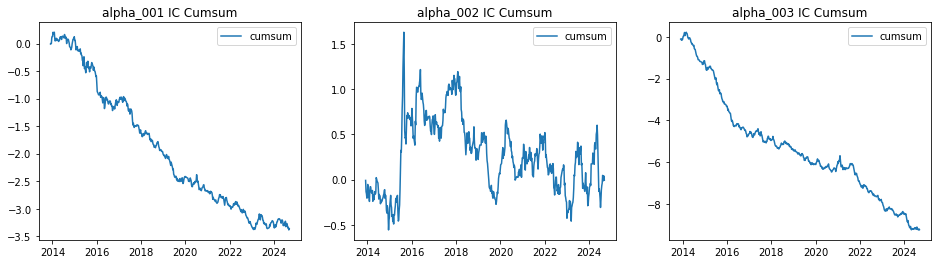

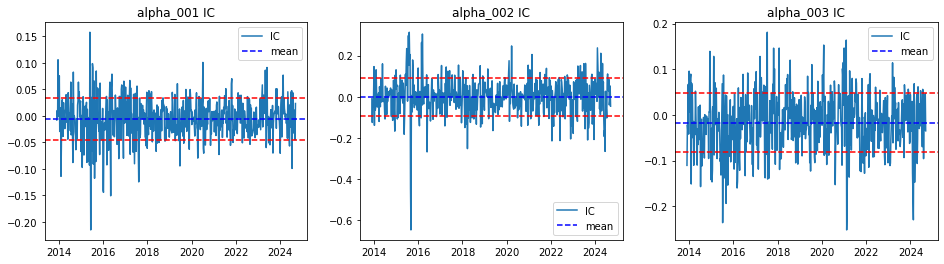

In [10]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(ICout['alpha_001']['Pearson']['cumsum'], label = 'cumsum')
plt.title('alpha_001 IC Cumsum')
plt.legend()

plt.subplot(1,3,2)
plt.plot(ICout['alpha_002']['Pearson']['cumsum'], label = 'cumsum')
plt.title('alpha_002 IC Cumsum')
plt.legend()

plt.subplot(1,3,3)
plt.plot(ICout['alpha_003']['Pearson']['cumsum'], label = 'cumsum')
plt.title('alpha_003 IC Cumsum')
plt.legend()
plt.show()

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(IC['alpha_001']['Pearson'], label = 'IC')
plt.axhline(ICout['alpha_001']['Pearson']['mean'], linestyle = '--', c = 'b', label = 'mean')
plt.axhline(ICout['alpha_001']['Pearson']['mean'] + ICout['alpha_001']['Pearson']['std'], linestyle = '--', c = 'r')
plt.axhline(ICout['alpha_001']['Pearson']['mean'] - ICout['alpha_001']['Pearson']['std'], linestyle = '--', c = 'r')
plt.title('alpha_001 IC')
plt.legend()

plt.subplot(1,3,2)
plt.plot(IC['alpha_002']['Pearson'], label = 'IC')
plt.axhline(ICout['alpha_002']['Pearson']['mean'], linestyle = '--', c = 'b', label = 'mean')
plt.axhline(ICout['alpha_002']['Pearson']['mean'] + ICout['alpha_002']['Pearson']['std'], linestyle = '--', c = 'r')
plt.axhline(ICout['alpha_002']['Pearson']['mean'] - ICout['alpha_002']['Pearson']['std'], linestyle = '--', c = 'r')
plt.title('alpha_002 IC')
plt.legend()

plt.subplot(1,3,3)
plt.plot(IC['alpha_003']['Pearson'], label = 'IC')
plt.axhline(ICout['alpha_003']['Pearson']['mean'], linestyle = '--', c = 'b', label = 'mean')
plt.axhline(ICout['alpha_003']['Pearson']['mean'] + ICout['alpha_003']['Pearson']['std'], linestyle = '--', c = 'r')
plt.axhline(ICout['alpha_003']['Pearson']['mean'] - ICout['alpha_003']['Pearson']['std'], linestyle = '--', c = 'r')
plt.title('alpha_003 IC')
plt.legend()
plt.show()

# 单因子回测分析

In [11]:
# 回测
train_date = dataset['bp'].index[:int(len(dataset['bp'].index) * 0.90)-1]
test_date = dataset['bp'].index[int(len(dataset['bp'].index) * 0.90)-1:]
trainset = {}
for key in factorset.keys():
    valid_index = factorset[key].index & train_date
    trainset[key] = factorset[key].loc[valid_index]

In [12]:
class Single(object):
    def __init__(self):
        pass
    
    def get_OLS(self, factor_data, return_data=dataset['ex_return']):
        if len(factor_data) > 1:
            prior_OUT1, prior_OLS1,_ = self.get_OLS(factor_data.iloc[:-1], return_data=dataset['ex_return'])
            prior_OUT2, prior_OLS2,_ = self.get_OLS(factor_data.iloc[-1:], return_data=dataset['ex_return'])
            if not len(prior_OUT1) or not len(prior_OLS1):
                prior_OUT1 = prior_OUT2
                prior_OLS1 = prior_OLS2
            else:
                prior_OUT1 = prior_OUT1.append(prior_OUT2)
                prior_OLS1 = prior_OLS1.append(prior_OLS2)

            # pre
            beita0 = prior_OLS1['beita0'].rolling(100,min_periods=1).mean()[-1]
            beita1 = prior_OLS1['beita1'].rolling(100,min_periods=1).mean()[-1]
            exreturn_pre = beita0 + beita1 * factor_data
            current_index = return_data.index.get_loc(exreturn_pre.index[-1])
            prior_OUT1.iloc[-1] = exreturn_pre.iloc[-1]
            return prior_OUT1, prior_OLS1, exreturn_pre
        
        else:
            current_index = return_data.index.get_loc(factor_data.index[0])
            if current_index+1 >= return_data.shape[0]:
                return pd.DataFrame({}), pd.DataFrame({}), pd.DataFrame({})
            data_1 = factor_data.iloc[0]
            data_2 = return_data.iloc[current_index+1]
            df = pd.DataFrame({'data_1': data_1, 'data_2': data_2})
            df = df.dropna()
            index_i = df.index
            x1 = np.array(df['data_1']).reshape(-1, 1)
            y = np.array(df['data_2']).reshape(-1, 1)
            if np.isnan(x1).all() or y.std()==0 or x1.std()==0:
                return pd.DataFrame({}), pd.DataFrame({}), pd.DataFrame({})
            X = sm.add_constant(x1)
            model = sm.OLS(y, X)
            outs = model.fit()
            out_pre = outs.predict(X)
            out_pre = pd.DataFrame({data_2.name:out_pre}, index=index_i)

            # 获取 R^2 和 t 值
            r2 = outs.rsquared  # 获取 R-squared
            cons_values, t1_values = outs.tvalues  # 获取 t 值
            beita0, beita1 = outs.params  # 获取系数
            ols_pre = pd.Series({'r2': r2, 't_cons': cons_values, 't_x1': t1_values, 'beita0': beita0, 'beita1': beita1},
                                   name = factor_data.index[0]).to_frame()
            return out_pre.T, ols_pre.T, None

    def backtrader(self, factor_data):
        total_cash = 100000
        Cash = {}
        out = {}
        y = {}
        print(f"回测时间：{test_date[0].strftime('%Y-%m-%d')} - {test_date[-1].strftime('%Y-%m-%d')} 共约：{len(test_date)}周")
        factor_pre, OLS_result, _ = self.get_OLS(factor_data)
        valid_test_indices = test_date & factor_pre.index
        
        Cash[valid_test_indices[0]] = total_cash
        for i in range(int(len(valid_test_indices) - 1)):
            selected_dates = valid_test_indices[i]
            return_pre = factor_pre.loc[selected_dates]
            top_30_indices = return_pre[return_pre > 0].sort_values(ascending=False).head(30).index
            #下一周期实际总收益率
            combination = np.mean(dataset['close_return'].loc[test_date[(i+1):((i+1)+1)]][top_30_indices], axis=0)
            # 等权配置股票各股数
            #each_price = dataset['open'].loc[selected_dates][top_30_indices]
            #each_price = dataset['close'].loc[valid_test_indices[i]][top_30_indices]
            #each_num = (total_cash / 30 / each_price).apply(np.floor)
            #combine_return = each_num * each_price * (1 + combination)
            #total_cash = total_cash + np.sum(each_num * each_price * combination)
            #InCash = np.sum(each_num*each_price)
            #OutCash = np.sum(combine_return)
            #combine_return = np.sum(combine_return) / np.sum(each_num*each_price) - 1
            # 等比例配置股票各股数
            each_price = dataset['close'].loc[valid_test_indices[i]][top_30_indices]
            if np.sum(each_price) == 0:
                each_num = 0
                combine_return = 0
                total_cash = total_cash
                InCash = 0
                OutCash = 0
                combine_return = 0
            else:
                each_num = np.floor(total_cash / np.sum(each_price))
                combine_return = each_num * each_price * (1 + combination)
                total_cash = total_cash + np.sum(each_num * each_price * combination)
                InCash = np.sum(each_num*each_price)
                OutCash = np.sum(combine_return)
                combine_return = np.sum(combine_return) / np.sum(each_num*each_price) - 1
            print(f"{selected_dates.strftime('%Y-%m-%d')}日：In {InCash:.2f} Out {OutCash:.2f} 收益率:{combine_return*100:.4f}%")
            y[selected_dates] = combine_return
            Cash[selected_dates] = total_cash
        combine_result = pd.DataFrame(list(y.items()), columns=['Date', 'Value'])
        combine_result.set_index('Date', inplace=True)
        Cash = pd.DataFrame(list(Cash.items()), columns=['Date', 'Value'])
        Cash.set_index('Date', inplace=True)
        # 回测指标
        # 年化收益率
        annualized_return = (1 + combine_result.mean())**52 - 1
        # 计算年化波动率
        annualized_volatility = combine_result.std() * np.sqrt(52)
        # 最大回撤
        cumulative_returns = (1 + combine_result).cumprod() - 1  # 累计收益率
        running_max = cumulative_returns.cummax()  # 累积的最大值
        drawdown = (cumulative_returns - running_max) / running_max  # 回撤
        max_drawdown = drawdown.min()  # 最大回撤
        # 夏普比率
        sharpe_ratio = annualized_return / annualized_volatility

        out['annualized_return'] = annualized_return.item()
        out['annualized_volatility'] = annualized_volatility.item()
        out['max_drawdown'] = max_drawdown.item()
        out['sharpe_ratio'] = sharpe_ratio.item()
        return combine_result, out, Cash, OLS_result

In [13]:
# 测试
#model = Single()
#a,b,c,d=model.backtrader(factorset['alpha_001'])

In [14]:
def Run_BackTrader():
    BackTraderResult = {}
    BackTraderOut = {}
    BackTraderCash = {}
    BackTraderOLS = {}
    for key in factorset.keys():
        print(key)
        model = Single()
        result, out, cash, ols_result = model.backtrader(factorset[key])
        BackTraderResult[key] = result
        BackTraderOut[key] = out
        BackTraderCash[key] = cash
        BackTraderOLS[key] = ols_result
    BackTraderResult = pd.concat(BackTraderResult,axis=1)
    BackTraderResult.columns = factorset.keys()
    BackTraderOut = pd.DataFrame(BackTraderOut)
    BackTraderCash = pd.concat(BackTraderCash,axis=1)
    BackTraderCash.columns = factorset.keys()
    BackTraderCash.fillna(method='ffill', inplace=True)
    return BackTraderResult, BackTraderOut, BackTraderCash, BackTraderOLS

BackTraderResult, BackTraderOut, BackTraderCash, OLS_result = Run_BackTrader()

mv
回测时间：2023-07-30 - 2024-09-13 共约：60周
2023-07-30日：In 99278.56 Out 99149.81 收益率:-0.1297%
2023-08-06日：In 99239.86 Out 97016.82 收益率:-2.2401%
2023-08-13日：In 97569.98 Out 96816.56 收益率:-0.7722%
2023-08-20日：In 96665.88 Out 99370.89 收益率:2.7983%
2023-08-27日：In 98966.08 Out 98368.31 收益率:-0.6040%
2023-09-03日：In 98290.24 Out 96243.70 收益率:-2.0821%
2023-09-10日：In 96297.17 Out 93457.72 收益率:-2.9486%
2023-09-17日：In 93960.41 Out 94862.75 收益率:0.9603%
2023-09-24日：In 94862.75 Out 95192.08 收益率:0.3472%
2023-10-01日：In 95248.05 Out 95248.05 收益率:0.0000%
2023-10-15日：In 95200.36 Out 92787.61 收益率:-2.5344%
2023-10-22日：In 92459.18 Out 89660.27 收益率:-3.0272%
2023-10-29日：In 90056.42 Out 93931.91 收益率:4.3034%
2023-11-05日：In 93383.73 Out 96988.08 收益率:3.8597%
2023-11-12日：In 97241.69 Out 101671.60 收益率:4.5556%
2023-11-19日：In 101916.44 Out 105326.35 收益率:3.3458%
2023-11-26日：In 105397.12 Out 106508.64 收益率:1.0546%
2023-12-03日：In 106331.50 Out 111451.72 收益率:4.8153%
2023-12-10日：In 111205.45 Out 112337.49 收益率:1.0180%
2023-12-17日：I

2023-07-30日：In 95438.62 Out 94864.61 收益率:-0.6014%
2023-08-06日：In 97935.41 Out 92876.35 收益率:-5.1657%
2023-08-13日：In 93357.87 Out 92007.57 收益率:-1.4464%
2023-08-20日：In 91995.36 Out 88483.38 收益率:-3.8176%
2023-08-27日：In 88217.36 Out 90081.26 收益率:2.1128%
2023-09-03日：In 90744.74 Out 88276.00 收益率:-2.7205%
2023-09-10日：In 88476.99 Out 88094.21 收益率:-0.4326%
2023-09-17日：In 87569.29 Out 87789.77 收益率:0.2518%
2023-09-24日：In 88182.15 Out 90611.06 收益率:2.7544%
2023-10-01日：In 0.00 Out 0.00 收益率:0.0000%
2023-10-22日：In 91102.96 Out 87964.84 收益率:-3.4446%
2023-10-29日：In 86686.08 Out 77720.07 收益率:-10.3431%
2023-11-05日：In 77570.90 Out 76184.10 收益率:-1.7878%
2023-11-12日：In 77488.53 Out 78694.30 收益率:1.5561%
2023-11-19日：In 77014.14 Out 77442.50 收益率:0.5562%
2023-11-26日：In 79179.69 Out 79997.33 收益率:1.0326%
2023-12-03日：In 79122.96 Out 77193.47 收益率:-2.4386%
2023-12-10日：In 77290.36 Out 76080.91 收益率:-1.5648%
2023-12-17日：In 76426.75 Out 73839.20 收益率:-3.3857%
2023-12-24日：In 71573.75 Out 69639.47 收益率:-2.7025%
2023-12-31日：In

2024-08-18日：In 195512.15 Out 196402.10 收益率:0.4552%
2024-08-25日：In 196493.24 Out 195799.65 收益率:-0.3530%
2024-09-01日：In 195553.70 Out 186871.91 收益率:-4.4396%
2024-09-08日：In 187111.79 Out 193258.24 收益率:3.2849%
alpha_005
回测时间：2023-07-30 - 2024-09-13 共约：60周
2023-07-30日：In 99443.13 Out 102062.26 收益率:2.6338%
2023-08-06日：In 102343.42 Out 100352.84 收益率:-1.9450%
2023-08-13日：In 99432.84 Out 97463.58 收益率:-1.9805%
2023-08-20日：In 97637.34 Out 92725.76 收益率:-5.0304%
2023-08-27日：In 92136.04 Out 96303.51 收益率:4.5232%
2023-09-03日：In 96110.31 Out 97271.54 收益率:1.2082%
2023-09-10日：In 96950.28 Out 98450.43 收益率:1.5473%
2023-09-17日：In 99868.61 Out 99585.12 收益率:-0.2839%
2023-09-24日：In 98461.21 Out 99046.90 收益率:0.5948%
2023-10-01日：In 99151.16 Out 99151.16 收益率:0.0000%
2023-10-15日：In 98879.30 Out 102760.43 收益率:3.9251%
2023-10-22日：In 104397.66 Out 100923.94 收益率:-3.3274%
2023-10-29日：In 101243.53 Out 104410.14 收益率:3.1277%
2023-11-05日：In 102517.38 Out 103036.53 收益率:0.5064%
2023-11-12日：In 102515.65 Out 103563.74 收益率:1.02

2024-08-25日：In 199290.49 Out 202029.71 收益率:1.3745%
2024-09-01日：In 200102.82 Out 202210.09 收益率:1.0531%
2024-09-08日：In 198725.63 Out 203166.16 收益率:2.2345%
alpha_008
回测时间：2023-07-30 - 2024-09-13 共约：60周
2023-07-30日：In 99609.58 Out 101514.77 收益率:1.9127%
2023-08-06日：In 101293.05 Out 98449.24 收益率:-2.8075%
2023-08-13日：In 99034.05 Out 98539.85 收益率:-0.4990%
2023-08-20日：In 97934.97 Out 95422.23 收益率:-2.5657%
2023-08-27日：In 95709.94 Out 102515.74 收益率:7.1109%
2023-09-03日：In 102674.22 Out 100988.74 收益率:-1.6416%
2023-09-10日：In 100978.01 Out 101736.59 收益率:0.7512%
2023-09-17日：In 101672.92 Out 102898.42 收益率:1.2053%
2023-09-24日：In 102778.41 Out 101902.22 收益率:-0.8525%
2023-10-01日：In 102157.28 Out 102157.28 收益率:0.0000%
2023-10-15日：In 102181.31 Out 104037.68 收益率:1.8167%
2023-10-22日：In 103919.42 Out 99200.18 收益率:-4.5412%
2023-10-29日：In 99334.45 Out 99570.29 收益率:0.2374%
2023-11-05日：In 98861.31 Out 101713.99 收益率:2.8855%
2023-11-12日：In 102371.49 Out 104253.73 收益率:1.8386%
2023-11-19日：In 104302.45 Out 109131.68 收益

2024-07-07日：In 79837.67 Out 71930.52 收益率:-9.9040%
2024-07-14日：In 71147.50 Out 71236.95 收益率:0.1257%
2024-07-21日：In 72608.40 Out 73110.53 收益率:0.6916%
2024-07-28日：In 72182.75 Out 70686.47 收益率:-2.0729%
2024-08-04日：In 71070.59 Out 69308.19 收益率:-2.4798%
2024-08-11日：In 68891.79 Out 69817.45 收益率:1.3436%
2024-08-18日：In 70441.68 Out 68761.88 收益率:-2.3847%
2024-08-25日：In 68420.40 Out 66252.59 收益率:-3.1684%
2024-09-01日：In 66982.36 Out 65512.13 收益率:-2.1950%
2024-09-08日：In 64818.44 Out 66131.43 收益率:2.0256%
alpha_011
回测时间：2023-07-30 - 2024-09-13 共约：60周
2023-07-30日：In 99121.47 Out 102652.73 收益率:3.5626%
2023-08-06日：In 103511.70 Out 100142.92 收益率:-3.2545%
2023-08-13日：In 98028.42 Out 96596.96 收益率:-1.4603%
2023-08-20日：In 97422.34 Out 92813.15 收益率:-4.7311%
2023-08-27日：In 93644.49 Out 100044.31 收益率:6.8342%
2023-09-03日：In 98043.68 Out 98268.47 收益率:0.2293%
2023-09-10日：In 97352.61 Out 97388.75 收益率:0.0371%
2023-09-17日：In 99311.46 Out 99384.77 收益率:0.0738%
2023-09-24日：In 100826.28 Out 100606.41 收益率:-0.2181%
2023-10

2024-07-14日：In 53901.85 Out 52931.16 收益率:-1.8008%
2024-07-21日：In 52708.04 Out 51769.60 收益率:-1.7804%
2024-07-28日：In 52005.23 Out 50387.83 收益率:-3.1101%
2024-08-04日：In 50323.60 Out 48463.07 收益率:-3.6971%
2024-08-11日：In 47932.11 Out 48566.71 收益率:1.3240%
2024-08-18日：In 48748.44 Out 48179.97 收益率:-1.1661%
2024-08-25日：In 48806.48 Out 47076.11 收益率:-3.5454%
2024-09-01日：In 46000.97 Out 43420.81 收益率:-5.6089%
2024-09-08日：In 44046.28 Out 45260.82 收益率:2.7574%
alpha_014
回测时间：2023-07-30 - 2024-09-13 共约：60周
2023-07-30日：In 97439.87 Out 97180.70 收益率:-0.2660%
2023-08-06日：In 97000.95 Out 96272.76 收益率:-0.7507%
2023-08-13日：In 98054.93 Out 92587.50 收益率:-5.5759%
2023-08-20日：In 90970.41 Out 87983.37 收益率:-3.2835%
2023-08-27日：In 89910.87 Out 91909.93 收益率:2.2234%
2023-09-03日：In 91234.82 Out 89629.91 收益率:-1.7591%
2023-09-10日：In 89509.91 Out 89477.93 收益率:-0.0357%
2023-09-17日：In 87643.85 Out 88842.90 收益率:1.3681%
2023-09-24日：In 88452.97 Out 89092.15 收益率:0.7226%
2023-10-01日：In 91867.22 Out 91867.22 收益率:0.0000%
2023-10-15

In [15]:
BackTraderOut.T

,annualized_return,annualized_volatility,max_drawdown,sharpe_ratio
mv,-0.182279,0.465185,-2.974724,-0.391841
bp,-0.223711,0.184499,-26.928265,-1.212533
alpha_001,-0.117105,0.222830,-6.967458,-0.525538
alpha_002,-0.244361,0.257841,-0.000000,-0.947722
alpha_003,-0.290934,0.225740,-9.384132,-1.288803
alpha_004,0.902081,0.277352,-2.297919,3.252477
alpha_005,-0.301364,0.199590,-5.599481,-1.509912
alpha_006,-0.308860,0.332883,-8.007115,-0.927833
alpha_007,1.103891,0.316762,-2.114728,3.484920
alpha_008,-0.475412,0.292566,-7.045332,-1.624973


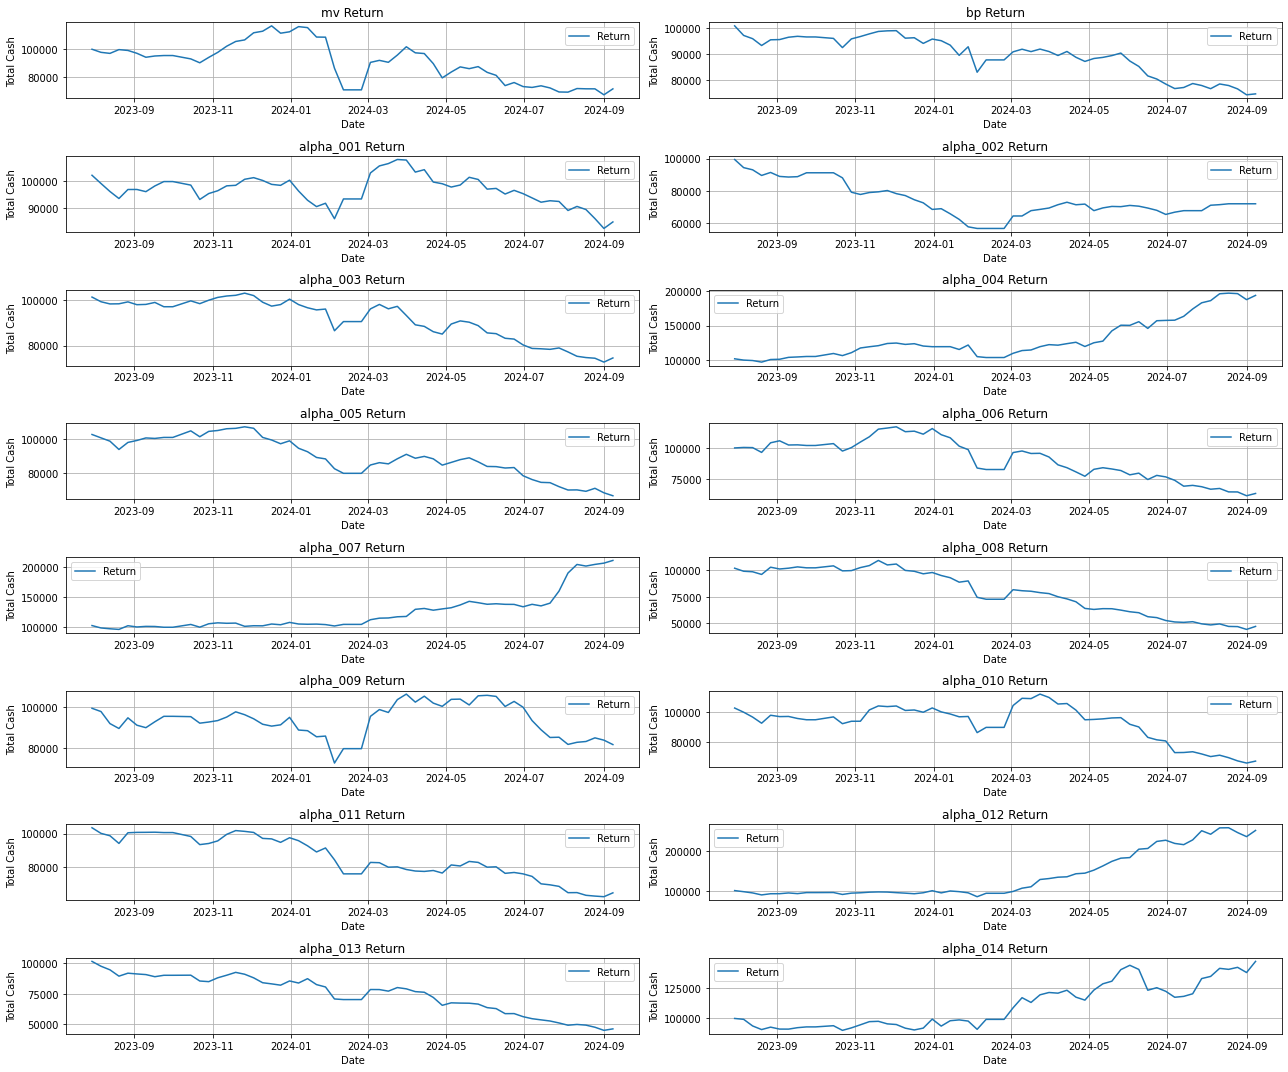

In [16]:
plt.figure(figsize=(18, 15))
for i, key in enumerate(factorset.keys()):
    plt.subplot(8,2,i+1)
    cumulative_result = BackTraderCash[key]
    plt.plot(cumulative_result.index, cumulative_result, label='Return')

    plt.title(f"{key} Return")
    plt.xlabel('Date')
    plt.ylabel('Total Cash')
    plt.legend()

    plt.grid(True)
    plt.tight_layout()
plt.show()

# 多因子回测
## 六因子模型

In [23]:
class Multy(object):
    def get_OLS(self, factor_data, return_data=dataset['ex_return']):
        if len(factor_data['mv']) > 1:
            dataset1 = {}
            dataset2 = {}
            for key in factor_data.keys():
                dataset1[key] = factor_data[key].iloc[:-1]
                dataset2[key] = factor_data[key].iloc[-1:]
            prior_OUT1, prior_OLS1,_ = self.get_OLS(dataset1, return_data=dataset['ex_return'])
            prior_OUT2, prior_OLS2,_ = self.get_OLS(dataset2, return_data=dataset['ex_return'])
            if not len(prior_OUT1) or not len(prior_OLS1):
                prior_OUT1 = prior_OUT2
                prior_OLS1 = prior_OLS2
            else:
                prior_OUT1 = prior_OUT1.append(prior_OUT2)
                prior_OLS1 = prior_OLS1.append(prior_OLS2)

            # pre
            beita0 = prior_OLS1['beita0'].rolling(100,min_periods=1).mean()[-1]
            beita1 = prior_OLS1['beita1'].rolling(100,min_periods=1).mean()[-1]
            beita2 = prior_OLS1['beita2'].rolling(100,min_periods=1).mean()[-1]
            beita3 = prior_OLS1['beita3'].rolling(100,min_periods=1).mean()[-1]
            beita4 = prior_OLS1['beita4'].rolling(100,min_periods=1).mean()[-1]
            beita5 = prior_OLS1['beita5'].rolling(100,min_periods=1).mean()[-1]
            beita6 = prior_OLS1['beita6'].rolling(100,min_periods=1).mean()[-1]
            exreturn_pre = beita0 + beita1 * factor_data['mv'] + beita2 * factor_data['bp'] + beita3 * factor_data['alpha_002'] + \
            beita4 * factor_data['alpha_004'] + beita5 * factor_data['alpha_007'] + beita6 * factor_data['alpha_014']
            current_index = return_data.index.get_loc(exreturn_pre.index[-1])
            prior_OUT1.iloc[-1] = exreturn_pre.iloc[-1]
            return prior_OUT1, prior_OLS1, exreturn_pre
        else:
            current_index = return_data.index.get_loc(factor_data['mv'].index[0])
            if current_index+1 >= return_data.shape[0]:
                return pd.DataFrame({}), pd.DataFrame({}), pd.DataFrame({})
            data_1 = factor_data['mv'].iloc[0]
            data_2 = factor_data['bp'].iloc[0]
            data_3 = factor_data['alpha_002'].iloc[0]
            data_4 = factor_data['alpha_004'].iloc[0]
            data_5 = factor_data['alpha_007'].iloc[0]
            data_6 = factor_data['alpha_014'].iloc[0]
            data_0 = return_data.iloc[current_index+1]
            df = pd.DataFrame({'data_1':data_1,'data_2':data_2,'data_3':data_3,'data_4':data_4,'data_5':data_5,'data_6':data_6,
                               'data_0':data_0})
            df = df.dropna()
            index_i = df.index
            x1 = np.array(df[['data_1','data_2','data_3','data_4','data_5','data_6']])
            y = np.array(df['data_0']).reshape(-1, 1)
            if np.isnan(x1).all() or y.std()==0 or np.any(x1.std(axis=0)==0):
                return pd.DataFrame({}), pd.DataFrame({}), pd.DataFrame({})
            X = sm.add_constant(x1)
            model = sm.OLS(y, X)
            outs = model.fit()
            out_pre = outs.predict(X)
            out_pre = pd.DataFrame({data_0.name:out_pre}, index=index_i)

            # 获取 R^2 和 t 值
            r2 = outs.rsquared  # 获取 R-squared
            cons_values,t1_values,t2_values,t3_values,t4_values,t5_values,t6_values=outs.tvalues
            beita0,beita1,beita2,beita3,beita4,beita5,beita6=outs.params  # 获取系数
            ols_pre = pd.Series({'r2':r2,'t_cons':cons_values,'t_x1':t1_values,'t_x2':t2_values,'t_x3':t3_values,'t_x4':t4_values,
                                    't_x5':t5_values,'t_x6':t6_values,'beita0':beita0,'beita1':beita1,'beita2':beita2,'beita3':beita3,
                                    'beita4':beita4,'beita5':beita5,'beita6':beita6}, name = factor_data['mv'].index[0]).to_frame()
            return out_pre.T, ols_pre.T, None

    def backtrader(self, factor_data):
        total_cash = 100000
        Cash = {}
        out = {}
        y = {}
        print(f"回测时间：{test_date[0].strftime('%Y-%m-%d')} - {test_date[-1].strftime('%Y-%m-%d')} 共约：{len(test_date)}周")
        valid_train_indices = train_date
        valid_test_indices = test_date
        train_data = {}
        test_data  ={}
        for key in factor_data.keys():
            valid_train_indices = valid_train_indices & factor_data[key].index
            valid_test_indices = valid_test_indices & factor_data[key].index
        for key in factor_data.keys():
            train_data[key] = factor_data[key].loc[valid_train_indices]
            test_data[key] = factor_data[key].loc[valid_test_indices]
        factor_pre, OLS_result, _ = self.get_OLS(factor_data)
        valid_test_indices = valid_test_indices & factor_pre.index
        Cash[valid_test_indices[0]] = total_cash
        for i in range(int(len(valid_test_indices) - 1)):
            selected_dates = valid_test_indices[i+1]
            return_pre = factor_pre.loc[selected_dates]
            top_30_indices = return_pre[return_pre > 0].sort_values(ascending=False).head(30).index
            #下一周期实际总收益率
            combination = np.mean(dataset['close_return'].loc[test_date[(i+1):((i+1)+1)]][top_30_indices], axis=0)
            # 等权配置股票各股数
            #each_price = dataset['close'].loc[valid_test_indices[i]][top_30_indices]
            #each_num = (total_cash / 30 / each_price).apply(np.floor)
            #combine_return = each_num * each_price * (1 + combination)
            #total_cash = total_cash + np.sum(each_num * each_price * combination)
            #InCash = np.sum(each_num*each_price)
            #OutCash = np.sum(combine_return)
            #combine_return = np.sum(combine_return) / np.sum(each_num*each_price) - 1
            # 等比例配置股票各股数
            each_price = dataset['close'].loc[valid_test_indices[i]][top_30_indices]
            if np.sum(each_price)==0:
                each_num = 0.0
                combine_return = 0.0
                total_cash = total_cash
                InCash = 0.0
                OutCash = 0.0
                combine_return = 0.0
            else:
                each_num = np.floor(total_cash / np.sum(each_price))
                combine_return = each_num * each_price * (1 + combination)
                total_cash = total_cash + np.sum(each_num * each_price * combination)
                InCash = np.sum(each_num*each_price)
                OutCash = np.sum(combine_return)
                combine_return = np.sum(combine_return) / np.sum(each_num*each_price) - 1
            
            print(f"{selected_dates.strftime('%Y-%m-%d')}日：In {InCash:.2f} Out {OutCash:.2f} 收益率:{combine_return*100:.4f}%")
            y[selected_dates] = combine_return
            Cash[selected_dates] = total_cash
        combine_result = pd.DataFrame(list(y.items()), columns=['Date', 'Value'])
        combine_result.set_index('Date', inplace=True)
        Cash = pd.DataFrame(list(Cash.items()), columns=['Date', 'Value'])
        Cash.set_index('Date', inplace=True)
        # 回测指标
        # 年化收益率
        annualized_return = (1 + combine_result.mean())**52 - 1
        # 计算年化波动率
        annualized_volatility = combine_result.std() * np.sqrt(52)
        # 最大回撤
        cumulative_returns = (1 + combine_result).cumprod() - 1  # 累计收益率
        running_max = cumulative_returns.cummax()  # 累积的最大值
        drawdown = (cumulative_returns - running_max) / running_max  # 回撤
        max_drawdown = drawdown.min()  # 最大回撤
        # 夏普比率
        sharpe_ratio = annualized_return / annualized_volatility

        out['annualized_return'] = annualized_return.item()
        out['annualized_volatility'] = annualized_volatility.item()
        out['max_drawdown'] = max_drawdown.item()
        out['sharpe_ratio'] = sharpe_ratio.item()
        return combine_result, out, Cash, OLS_result
model1 = Multy()
BackTraderResult, BackTraderOut, BackTraderCash, BackTrader_OLS_result = model1.backtrader(factorset)
BackTraderOut = pd.DataFrame(BackTraderOut,index=['Evaluate'])
BackTraderCash.fillna(method='ffill', inplace=True)
BackTraderOut

回测时间：2023-07-30 - 2024-09-13 共约：60周
2023-08-06日：In 99496.22 Out 99699.61 收益率:0.2044%
2023-08-13日：In 100112.58 Out 99796.42 收益率:-0.3158%
2023-08-20日：In 99425.05 Out 99300.23 收益率:-0.1255%
2023-08-27日：In 98136.16 Out 95414.42 收益率:-2.7734%
2023-09-03日：In 96949.24 Out 101460.38 收益率:4.6531%
2023-09-10日：In 101451.20 Out 101061.64 收益率:-0.3840%
2023-09-17日：In 98629.43 Out 99504.69 收益率:0.8874%
2023-09-24日：In 99822.59 Out 99817.86 收益率:-0.0047%
2023-10-01日：In 0.00 Out 0.00 收益率:0.0000%
2023-10-22日：In 100771.11 Out 100771.11 收益率:0.0000%
2023-10-29日：In 99078.72 Out 97348.91 收益率:-1.7459%
2023-11-05日：In 99518.47 Out 96202.69 收益率:-3.3318%
2023-11-12日：In 96332.72 Out 101914.46 收益率:5.7942%
2023-11-19日：In 102107.84 Out 102828.52 收益率:0.7058%
2023-11-26日：In 102900.31 Out 104762.55 收益率:1.8098%
2023-12-03日：In 104326.91 Out 105540.96 收益率:1.1637%
2023-12-10日：In 103983.85 Out 106495.28 收益率:2.4152%
2023-12-17日：In 108833.70 Out 109067.21 收益率:0.2146%
2023-12-24日：In 107609.38 Out 105198.78 收益率:-2.2401%
2023-12-31日：In

,annualized_return,annualized_volatility,max_drawdown,sharpe_ratio
Evaluate,0.142761,0.370301,-15.696008,0.385526


## 简化F-F模型

In [18]:
class FFMulty(object):
    def get_OLS(self, factor_data, return_data=dataset['ex_return']):
        if len(factor_data['mv']) > 1:
            dataset1 = {}
            dataset2 = {}
            for key in factor_data.keys():
                dataset1[key] = factor_data[key].iloc[:-1]
                dataset2[key] = factor_data[key].iloc[-1:]
            prior_OUT1, prior_OLS1,_ = self.get_OLS(dataset1, return_data=dataset['ex_return'])
            prior_OUT2, prior_OLS2,_ = self.get_OLS(dataset2, return_data=dataset['ex_return'])
            if not len(prior_OUT1) or not len(prior_OLS1):
                prior_OUT1 = prior_OUT2
                prior_OLS1 = prior_OLS2
            else:
                prior_OUT1 = prior_OUT1.append(prior_OUT2)
                prior_OLS1 = prior_OLS1.append(prior_OLS2)

            # pre
            beita0 = np.mean(prior_OLS1['beita0'])
            beita1 = np.mean(prior_OLS1['beita1'])
            beita2 = np.mean(prior_OLS1['beita2'])
            exreturn_pre = beita0 + beita1 * factor_data['mv'] + beita2 * factor_data['bp']
            current_index = return_data.index.get_loc(exreturn_pre.index[-1])
            prior_OUT1.iloc[-1] = exreturn_pre.iloc[-1]
            return prior_OUT1, prior_OLS1, exreturn_pre
        else:
            current_index = return_data.index.get_loc(factor_data['mv'].index[0])
            if current_index+1 >= return_data.shape[0]:
                return pd.DataFrame({}), pd.DataFrame({}), pd.DataFrame({})
            data_1 = factor_data['mv'].iloc[0]
            data_2 = factor_data['bp'].iloc[0]
            data_0 = return_data.iloc[current_index+1]
            df = pd.DataFrame({'data_1':data_1,'data_2':data_2,'data_0':data_0})
            df = df.dropna()
            index_i = df.index
            x1 = np.array(df[['data_1','data_2']])
            y = np.array(df['data_0']).reshape(-1, 1)
            if np.isnan(x1).all() or y.std()==0 or np.any(x1.std(axis=0)==0):
                return pd.DataFrame({}), pd.DataFrame({}), pd.DataFrame({})
            X = sm.add_constant(x1)
            model = sm.OLS(y, X)
            outs = model.fit()
            out_pre = outs.predict(X)
            out_pre = pd.DataFrame({data_0.name:out_pre}, index=index_i)

            # 获取 R^2 和 t 值
            r2 = outs.rsquared  # 获取 R-squared
            cons_values,t1_values,t2_values=outs.tvalues
            beita0,beita1,beita2=outs.params  # 获取系数
            ols_pre = pd.Series({'r2':r2,'t_cons':cons_values,'t_x1':t1_values,'t_x2':t2_values,'beita0':beita0,
                                 'beita1':beita1,'beita2':beita2}, name = factor_data['mv'].index[0]).to_frame()
            return out_pre.T, ols_pre.T, None

    def backtrader(self, factor_data):
        total_cash = 100000
        Cash = {}
        out = {}
        y = {}
        print(f"回测时间：{test_date[0].strftime('%Y-%m-%d')} - {test_date[-1].strftime('%Y-%m-%d')} 共约：{len(test_date)}周")
        valid_train_indices = train_date
        valid_test_indices = test_date
        train_data = {}
        test_data  ={}
        for key in factor_data.keys():
            valid_train_indices = valid_train_indices & factor_data[key].index
            valid_test_indices = valid_test_indices & factor_data[key].index
        for key in factor_data.keys():
            train_data[key] = factor_data[key].loc[valid_train_indices]
            test_data[key] = factor_data[key].loc[valid_test_indices]
        factor_pre, OLS_result, _ = self.get_OLS(factor_data)
        valid_test_indices = valid_test_indices & factor_pre.index
        Cash[valid_test_indices[0]] = total_cash
        for i in range(int(len(valid_test_indices) - 1)):
            selected_dates = valid_test_indices[i+1]
            return_pre = factor_pre.loc[selected_dates]
            top_30_indices = return_pre[return_pre > 0].sort_values(ascending=False).head(30).index
            #下一周期实际总收益率
            combination = np.mean(dataset['close_return'].loc[test_date[(i+1):((i+1)+1)]][top_30_indices], axis=0)
            # 等比例配置股票各股数
            each_price = dataset['close'].loc[valid_test_indices[i]][top_30_indices]
            if np.sum(each_price)==0:
                each_num = 0.0
                combine_return = 0.0
                total_cash = total_cash
                InCash = 0.0
                OutCash = 0.0
                combine_return = 0.0
            else:
                each_num = np.floor(total_cash / np.sum(each_price))
                combine_return = each_num * each_price * (1 + combination)
                total_cash = total_cash + np.sum(each_num * each_price * combination)
                InCash = np.sum(each_num*each_price)
                OutCash = np.sum(combine_return)
                combine_return = np.sum(combine_return) / np.sum(each_num*each_price) - 1
            
            print(f"{selected_dates.strftime('%Y-%m-%d')}日：In {InCash:.2f} Out {OutCash:.2f} 收益率:{combine_return*100:.4f}%")
            y[selected_dates] = combine_return
            Cash[selected_dates] = total_cash
        combine_result = pd.DataFrame(list(y.items()), columns=['Date', 'Value'])
        combine_result.set_index('Date', inplace=True)
        Cash = pd.DataFrame(list(Cash.items()), columns=['Date', 'Value'])
        Cash.set_index('Date', inplace=True)
        # 回测指标
        # 年化收益率
        annualized_return = (1 + combine_result.mean())**52 - 1
        # 计算年化波动率
        annualized_volatility = combine_result.std() * np.sqrt(52)
        # 最大回撤
        cumulative_returns = (1 + combine_result).cumprod() - 1  # 累计收益率
        running_max = cumulative_returns.cummax()  # 累积的最大值
        drawdown = (cumulative_returns - running_max) / running_max  # 回撤
        max_drawdown = drawdown.min()  # 最大回撤
        # 夏普比率
        sharpe_ratio = annualized_return / annualized_volatility

        out['annualized_return'] = annualized_return.item()
        out['annualized_volatility'] = annualized_volatility.item()
        out['max_drawdown'] = max_drawdown.item()
        out['sharpe_ratio'] = sharpe_ratio.item()
        return combine_result, out, Cash, OLS_result
model2 = FFMulty()
FFResult, FFOut, FFCash, FF_OLS_result = model2.backtrader(factorset)
FFOut = pd.DataFrame(FFOut,index=['Evaluate'])
FFCash.fillna(method='ffill', inplace=True)
FFOut

回测时间：2023-07-30 - 2024-09-13 共约：60周
2023-08-06日：In 98746.87 Out 100288.99 收益率:1.5617%
2023-08-13日：In 100124.62 Out 96301.64 收益率:-3.8182%
2023-08-20日：In 96301.64 Out 94867.50 收益率:-1.4892%
2023-08-27日：In 95381.61 Out 92531.91 收益率:-2.9877%
2023-09-03日：In 91816.35 Out 94120.24 收益率:2.5092%
2023-09-10日：In 94995.52 Out 95171.23 收益率:0.1850%
2023-09-17日：In 95732.28 Out 96702.99 收益率:1.0140%
2023-09-24日：In 95196.23 Out 95723.52 收益率:0.5539%
2023-10-01日：In 95815.92 Out 95651.92 收益率:-0.1712%
2023-10-15日：In 95651.92 Out 95651.92 收益率:0.0000%
2023-10-22日：In 97246.92 Out 96716.12 收益率:-0.5458%
2023-10-29日：In 95311.03 Out 91349.01 收益率:-4.1569%
2023-11-05日：In 92359.33 Out 94583.11 收益率:2.4077%
2023-11-12日：In 94225.19 Out 94607.00 收益率:0.4052%
2023-11-19日：In 94644.52 Out 95873.51 收益率:1.2985%
2023-11-26日：In 95506.69 Out 96424.26 收益率:0.9607%
2023-12-03日：In 96430.12 Out 97002.73 收益率:0.5938%
2023-12-10日：In 97335.22 Out 96606.05 收益率:-0.7491%
2023-12-17日：In 96178.16 Out 92556.56 收益率:-3.7655%
2023-12-24日：In 93192.17

,annualized_return,annualized_volatility,max_drawdown,sharpe_ratio
Evaluate,-0.322001,0.19761,-24.218335,-1.629478


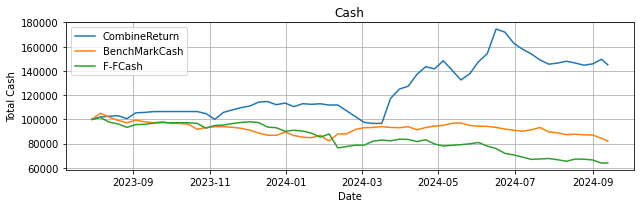

In [19]:
benchindex = dataset['benchmark_return'].index.get_loc(BackTraderCash.index[0])
benchreturn = np.cumsum(dataset['benchmark_return'].iloc[benchindex:])
benchreturn.iloc[0] = 0
BenchMarkCash = 100000 * (benchreturn+1)

plt.figure(figsize=(9,3))
cumulative_result = BackTraderCash
plt.plot(cumulative_result.index, cumulative_result, label='CombineReturn')
cumulative_result = BenchMarkCash
plt.plot(cumulative_result.index, cumulative_result, label='BenchMarkCash')
cumulative_result = FFCash
plt.plot(cumulative_result.index, cumulative_result, label='F-FCash')
plt.title("Cash")
plt.xlabel('Date')
plt.ylabel('Total Cash')
plt.legend()

plt.grid(True)
plt.tight_layout()

# 回归假设检验

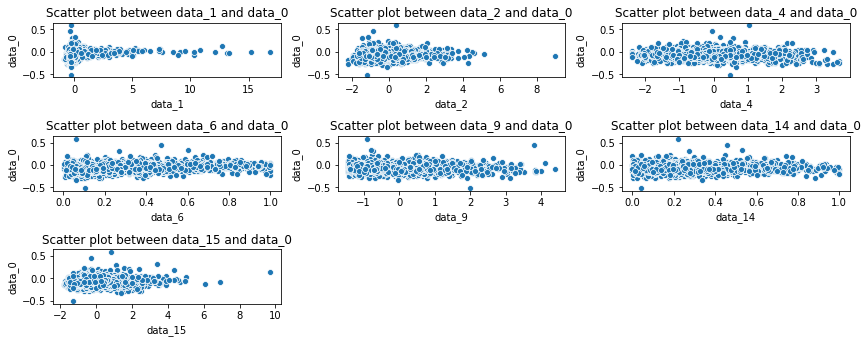

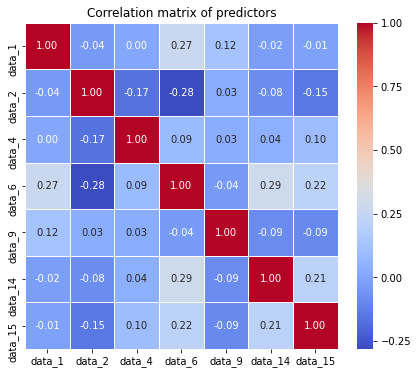

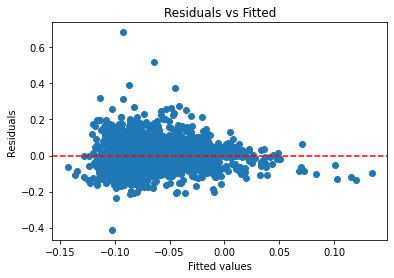

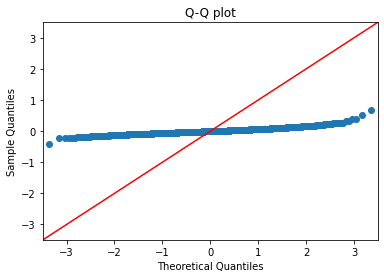

Shapiro-Wilk test p-value: 1.0280882132587324e-26


,Variable,VIF
0,const,3.676179
1,data_1,1.119021
2,data_2,1.122029
3,data_4,1.038263
4,data_6,1.315952
5,data_9,1.033202
6,data_14,1.133316
7,data_15,1.099623


In [20]:
# i=1
day = '2024-04-14'
data_1 = factorset['mv'].loc[day] #.iloc[-(i+1)]
data_2 = factorset['bp'].loc[day] #.iloc[-(i+1)]
data_3 = factorset['alpha_001'].loc[day] #.iloc[-(i+1)]
data_4 = factorset['alpha_002'].loc[day] #.iloc[-(i+1)]
data_5 = factorset['alpha_003'].loc[day] #.iloc[-(i+1)]
data_6 = factorset['alpha_004'].loc[day] #.iloc[-(i+1)]
data_7 = factorset['alpha_005'].loc[day] #.iloc[-(i+1)]
data_8 = factorset['alpha_006'].loc[day] #.iloc[-(i+1)]
data_9 = factorset['alpha_007'].loc[day] #.iloc[-(i+1)]
data_10 = factorset['alpha_008'].loc[day] #.iloc[-(i+1)]
data_11 = factorset['alpha_009'].loc[day] #.iloc[-(i+1)]
data_12 = factorset['alpha_010'].loc[day] #.iloc[-(i+1)]
data_13 = factorset['alpha_011'].loc[day] #.iloc[-(i+1)]
data_14 = factorset['alpha_012'].loc[day] #.iloc[-(i+1)]
data_15 = factorset['alpha_013'].loc[day] #.iloc[-(i+1)]
data_16 = factorset['alpha_014'].loc[day] #.iloc[-(i+1)]
data_0 = dataset['ex_return'].shift(-1).loc[day]
df = pd.DataFrame({'data_1':data_1,'data_2':data_2,'data_4':data_4,'data_6':data_6,
                   'data_9':data_9,'data_14':data_14,'data_15':data_15,'data_0':data_0})

df = df.dropna()

plt.figure(figsize=(12,6))
for i,col in enumerate(df.columns[:-1]):
    plt.subplot(4,3,i+1)
    sns.scatterplot(x=df[col], y=df['data_0'])
    plt.title(f'Scatter plot between {col} and data_0')
    plt.xlabel(col)
    plt.ylabel('data_0')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,6))
corr_matrix = df[df.columns[:-1]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation matrix of predictors')
plt.show()

X = df[df.columns[:-1]]
X = sm.add_constant(X)
y = df['data_0']
model = sm.OLS(y, X).fit()
residuals = model.resid

# 绘制残差图
plt.scatter(model.fittedvalues, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

# 绘制 Q-Q 图
sm.qqplot(residuals, line ='45')
plt.title('Q-Q plot')
plt.show()

# Shapiro-Wilk 正态性检验
stat, p_value = stats.shapiro(residuals)
print(f"Shapiro-Wilk test p-value: {p_value}")

# VIF 多重共线性检验
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

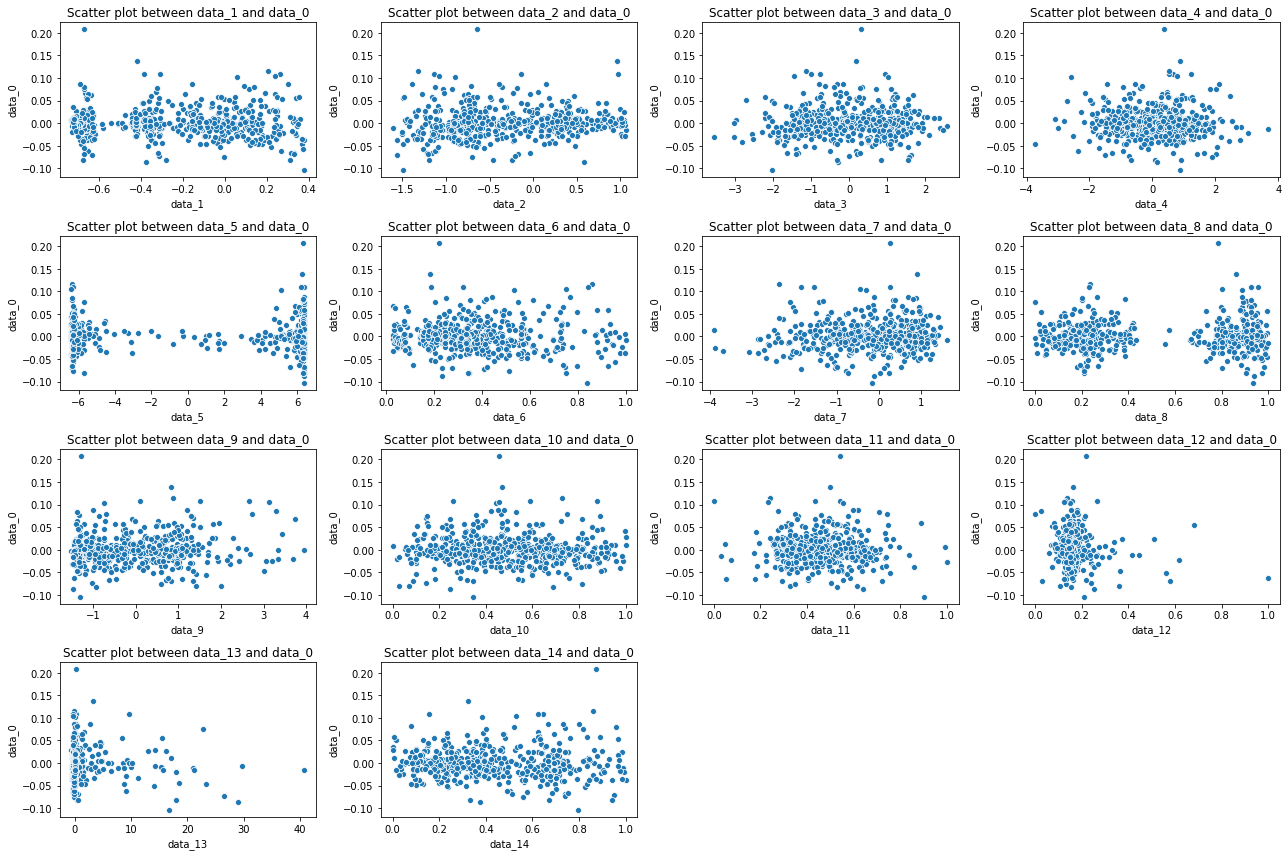

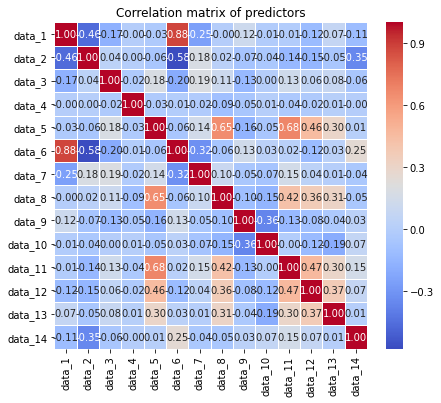

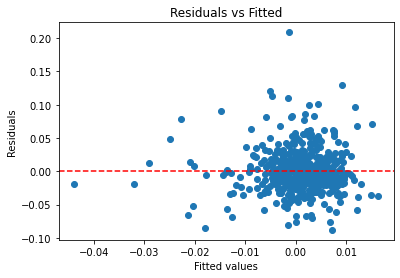

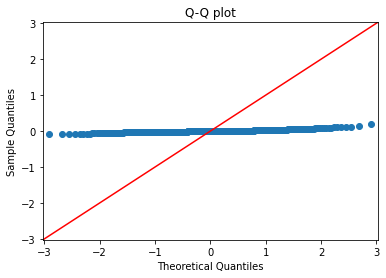

Shapiro-Wilk test p-value: 9.964083721728987e-16
   Variable        VIF
0     const  72.799468
1    data_1   9.561299
2    data_2   1.771857
3    data_3   1.118382
4    data_4   1.019760
5    data_5   2.746747
6    data_6  10.512952
7    data_7   1.203287
8    data_8   1.870402
9    data_9   1.248570
10  data_10   1.273656
11  data_11   2.102028
12  data_12   1.590335
13  data_13   1.282383
14  data_14   2.445392


In [21]:
key=factorset['mv'].columns[0]
data_1 = factorset['mv'][key]
data_2 = factorset['bp'][key]
data_3 = factorset['alpha_001'][key]
data_4 = factorset['alpha_002'][key]
data_5 = factorset['alpha_003'][key]
data_6 = factorset['alpha_004'][key]
data_7 = factorset['alpha_005'][key]
data_8 = factorset['alpha_006'][key]
data_9 = factorset['alpha_007'][key]
data_10 = factorset['alpha_008'][key]
data_11 = factorset['alpha_009'][key]
data_12 = factorset['alpha_010'][key]
data_13 = factorset['alpha_011'][key]
data_14 = factorset['alpha_012'][key]
data_0 = dataset['ex_return'][key].shift(-1)
df = pd.DataFrame({'data_1':data_1,'data_2':data_2,'data_3':data_3,'data_4':data_4,'data_5':data_5,'data_6':data_6,
                   'data_7':data_7,'data_8':data_8,'data_9':data_9,'data_10':data_10,'data_11':data_11,'data_12':data_12,
                   'data_13':data_13,'data_14':data_14,'data_0':data_0})
df = df.dropna()

plt.figure(figsize=(18,12))
for i,col in enumerate(df.columns[:-1]):
    plt.subplot(4,4,i+1)
    sns.scatterplot(x=df[col], y=df['data_0'])
    plt.title(f'Scatter plot between {col} and data_0')
    plt.xlabel(col)
    plt.ylabel('data_0')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,6))
corr_matrix = df[df.columns[:-1]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation matrix of predictors')
plt.show()

X = df[df.columns[:-1]]
X = sm.add_constant(X)
y = df['data_0']
model = sm.OLS(y, X).fit()
residuals = model.resid

# 绘制残差图
plt.scatter(model.fittedvalues, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

# 绘制 Q-Q 图
sm.qqplot(residuals, line ='45')
plt.title('Q-Q plot')
plt.show()

# Shapiro-Wilk 正态性检验
stat, p_value = stats.shapiro(residuals)
print(f"Shapiro-Wilk test p-value: {p_value}")

# VIF 多重共线性检验
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)